# Continuous-time LQ-optimal control on a finite time interval with a fixed final state

We consider an LTI state-space model (but can also be time-varying), a quadratic cost function and fixed initial and final states, all this on an interval $[0,t_\mathrm{f}]$.

\begin{align*}
 \underset{\mathbf x(t),\mathbf u(t)}{\text{minimize}}&\quad\int_{0}^{t_\mathbf f}\left(\mathbf x^\text{T}(t)\underbrace{\mathbf Q}_{\geq 0}\mathbf x(t)+\mathbf u^\text{T}(t)\underbrace{\mathbf R}_{>0} u(t)\right)\text{d}t\\
 \text{subject to}&\quad \dot{\mathbf x}(t)= \mathbf A\mathbf x(t)+ \mathbf B\mathbf u(t),\\
 &\quad \mathbf{x}(0) = \mathbf{r}_0,\\
  &\quad \mathbf x(t_\mathrm{f})=\mathbf r_\mathrm{f}. 
\end{align*}

## Two-point boundary value problem

The corresponding first-order necessary conditions come in the form of a two-point boundary value problem

\begin{equation*}
\begin{bmatrix}
 \dot {\mathbf x} \\ \dot{\boldsymbol\lambda}
\end{bmatrix}
= \underbrace{
\begin{bmatrix}
 \mathbf A & \mathbf B\mathbf R^{-1}\mathbf B^\text{T}\\
 \mathbf Q & - \mathbf A^\text{T}
\end{bmatrix}}_{\mathbf H}
\begin{bmatrix}
 \mathbf x \\ \boldsymbol\lambda
\end{bmatrix},
\end{equation*}

\begin{align*}
\mathbf x(t_\mathrm{i})&=\mathbf r_\mathrm{i},\\
\mathbf x(t_\mathrm{f})&=\mathbf r_\mathrm{f}(t_\mathrm{f}).
\end{align*}

once we have the solution, the optimal control can be obtained via

\begin{equation*}
 \mathbf u(t) = \mathbf R^{-1}\mathbf B^\text{T}\boldsymbol \lambda(t).
\end{equation*}

Let's enter the matrices defining the models in Julia

In [14]:
n = 2                  # order of the system

A = rand(n,n)
B = rand(n,1)

2×1 Array{Float64,2}:
 0.9202738284109997
 0.22415045715869697

Specify also the cost function (by giving the two weighting matrices)

In [23]:
using LinearAlgebra

Q = diagm(0=>rand(n))  
R = rand(1,1)

1×1 Array{Float64,2}:
 0.6446121625840247

Fix also the boundary values of the state variable(s) 

In [16]:
x0 = [1;2]             # initial states
x1 = [0;3]             # final (desired) states

2-element Array{Int64,1}:
 0
 3

and the final time

In [24]:
t1 = 10                # had to change from tf because of some possible clash with ControlSystems later

10

Now we build the Hamiltonian matrix 

In [18]:
H = [A B/R*B'; Q -A'] # the combined matrix for the Hamiltonian cannonical equations

4×4 Array{Float64,2}:
 0.470769  0.633008   1.00907    0.245778
 0.837483  0.238654   0.245778   0.059864
 0.691988  0.0       -0.470769  -0.837483
 0.0       0.452589  -0.633008  -0.238654

The Hamiltonian matrix $\mathbf H$ defines a linear system. As such its solution can be expressed using the state transition matrix (in fact, a matrix exponential)

In [25]:
P = exp(H*tf)        

P11 = P[1:n,1:n]
P12 = P[1:n,n+1:end]
P21 = P[n+1:end,1:n]
P22 = P[n+1:end,n+1:end]

lambda0 = P12\(x1-P11*x0);  # solving for the initial value of costate

We are now ready to solving for the Hamiltonian system for the states and the costates during the time interval. In order to do that, we can use [ControlSystems](https://github.com/JuliaControl/ControlSystems.jl) package (after defining a dummy systems, which is actually the Hamiltonian canonical equations with no input and all the states at the output). Alternatively, we could solve this using [DifferentialEquations](https://docs.juliadiffeq.org/latest/) package.

In [20]:
using ControlSystems

G = ss(H,zeros(2n,1),Matrix{Float64}(I, 2n, 2n),0) # auxiliary system comprising the states and costates

w0 = [x0; lambda0]
t = 0:0.1:t1
v(w,t) = [0]
y, t, w, uout = lsim(G,v,t,x0=w0)
x = w[:,1:n]                         # state
λ = w[:,n+1:end]                     # costate

101×2 Array{Float64,2}:
 -4.237     -4.89619
 -3.60495   -4.4467
 -3.05812   -4.04517
 -2.58549   -3.68589
 -2.17748   -3.36387
 -1.8257    -3.0747
 -1.52287   -2.81453
 -1.2626    -2.57999
 -1.03936   -2.36811
 -0.84831   -2.17627
 -0.68523   -2.00219
 -0.546449  -1.84383
 -0.428782  -1.69944
  ⋮         
 -2.98158    4.22691
 -3.14511    4.43157
 -3.31886    4.64537
 -3.50367    4.86864
 -3.70046    5.10175
 -3.91024    5.34504
 -4.13419    5.59886
 -4.3736     5.86354
 -4.62994    6.13939
 -4.90482    6.42672
 -5.20001    6.72583
 -5.51742    7.03702

Finally, once we have the states and the costates over the whole interval, the optimal control immediately follows from the stationarity equation (of course only under the assumption of nonsingularity of $\mathbf R$, which is what we imposed at the beginning by asking for $\mathbf R>0$).

In [26]:
u = (R\B'*λ')';  # optimal control from the stationarity equation

Plotting the responses shows if we succeeded in satisfying the requirements on the initial and final conditions.

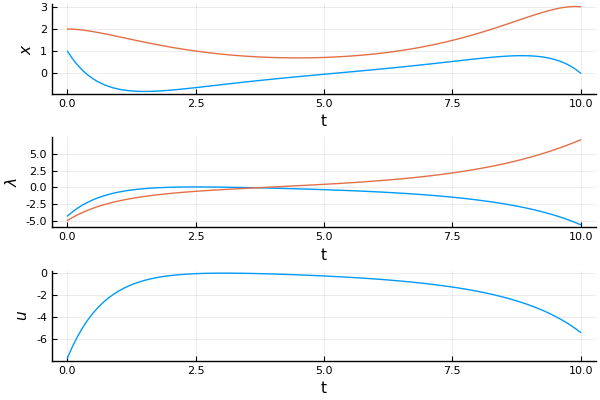

In [27]:
using Plots, LaTeXStrings
pyplot(xlabel="t",legend=false)

p1 = plot(t,x,ylabel=L"x")
p2 = plot(t,λ,ylabel=L"$\lambda$")
p3 = plot(t,u,ylabel=L"u")

plot(p1,p2,p3,layout=(3,1))

## Minimum energy control (assuming $\mathbf Q = \mathbf 0$)

[TBD: gramian stuff]